In [1]:
#add auto reload for src function testing
%load_ext autoreload
%autoreload 2

#let's add the project directory to our module path
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
#also import all of our modules
import pandas as pd
import numpy as np
from scipy import stats
from src import data_cleaning

#and here is our data directiory
data_folder = '../../data/'

# Initial Import

In [2]:
rp_sale = pd.read_csv(data_folder+'EXTR_RPSale.csv', dtype={'Major': 'str', 'Minor':'str'})
res_bldg = pd.read_csv(data_folder+'EXTR_ResBldg.csv', dtype={'Major': 'str', 'Minor':'str', 'ZipCode': 'str'})

# Data filtering

We are looking at property that:
1. was sold in 2019, to see the factors that affect the current market.

2. is residential, as opposed to commercial.

3. was sold, as opposed to foreclosed or transferred as part of a settlement.

4. was not sold via a Quit Claim Deed nor a Statutory Warranty Deed, as these deeds are not typically used by new homeowners.

5. has one building on the parcel, to accurately infer the characteristics of the house sold.



# 1. Was sold in 2019

This filter cuts the most substantial amount of entries from our data set, which records sales from at least a few decades ago.

In [3]:
filter_one = data_cleaning.filter_data_by_year(rp_sale, 2019)
filter_one

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
72,2999169,919715,0200,2019-07-08,192000,20190712001080,,,,,...,3,2,3,N,N,N,N,1,3,
236,3000673,894444,0200,2019-06-26,185000,20190722001395,,,,,...,3,2,3,N,N,N,N,1,3,
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
446,3018109,152504,9008,2019-10-18,7600000,20191030001615,,,,,...,3,7,3,N,N,N,N,1,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31
2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,,...,11,6,15,N,N,N,N,1,8,
2087907,3028691,277110,4239,2019-12-19,955000,20200103000685,,,,,...,10,6,3,N,N,N,N,1,8,


It cuts about 2 million entries.

In [4]:
len(filter_one) - len(rp_sale)

-2026593

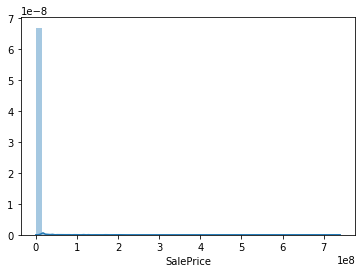

In [5]:
import seaborn as sns

sns.distplot(filter_one.SalePrice)

# 2. Is listed as some sale other than foreclosures, settlements, etc. 
ie a standard sale.

In [6]:
filter_two = filter_one[(filter_one['SaleReason']==1)|(filter_one['SaleReason']==18)]
filter_two

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
72,2999169,919715,0200,2019-07-08,192000,20190712001080,,,,,...,3,2,3,N,N,N,N,1,3,
236,3000673,894444,0200,2019-06-26,185000,20190722001395,,,,,...,3,2,3,N,N,N,N,1,3,
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
446,3018109,152504,9008,2019-10-18,7600000,20191030001615,,,,,...,3,7,3,N,N,N,N,1,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31
2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,,...,11,6,15,N,N,N,N,1,8,
2087907,3028691,277110,4239,2019-12-19,955000,20200103000685,,,,,...,10,6,3,N,N,N,N,1,8,


This removes very little of are data. This is unsurprising because most non-standard sales are listed with a zero sale price and were thus filtered out with the previous non-zero filter.

In [7]:
len(filter_two) - len(filter_one)

-5994

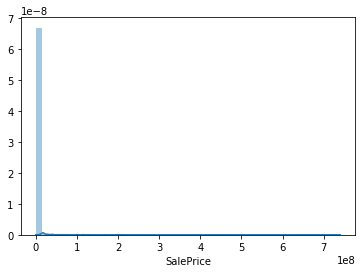

In [8]:
sns.distplot(filter_two.SalePrice)

# 3. Is residential
Because we are targetting prospective homeowners, we don't want to look at commercial buildings.

In [9]:
filter_three = filter_two[(filter_two['PropertyClass'] == 7)|(filter_two['PropertyClass'] == 8)]
filter_three

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,3,6,3,N,N,N,N,1,8,
482,3015516,779790,0030,2019-10-07,0,20191016000009,,,,,...,11,6,3,N,N,N,N,1,8,
594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,3,6,15,N,N,N,N,18,8,18 51 52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31
2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,,...,11,6,15,N,N,N,N,1,8,
2087907,3028691,277110,4239,2019-12-19,955000,20200103000685,,,,,...,10,6,3,N,N,N,N,1,8,


This is a substantial filter, removing approximately 25% of our data.

In [10]:
len(filter_three) - len(filter_two)

-13121

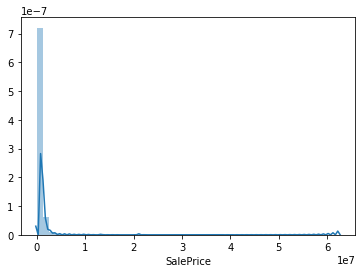

In [11]:
sns.distplot(filter_three.SalePrice)

# 4. Was not sold for zero dollars

In [12]:
filter_four = filter_three[filter_three['SalePrice'] != 0]
filter_four


,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,11,6,3,N,N,N,N,1,8,
302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,11,6,3,N,N,N,N,1,8,
465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,3,6,3,N,N,N,N,1,8,
594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,3,6,15,N,N,N,N,18,8,18 51 52
599,2980648,797320,2320,2019-03-27,540000,,,,,,...,3,6,3,N,N,N,N,1,8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,,...,11,6,3,N,N,N,N,1,8,
2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,,...,11,6,3,N,N,N,N,1,8,
2087782,2986698,033310,0255,2019-04-30,6500000,20190508000847,,,,,...,11,6,3,N,N,N,N,1,8,
2087856,2980997,334840,1022,2019-04-03,29000,20190405000544,,,,,...,1,6,18,N,N,N,N,18,7,13 31


This is our second most substantial filter, removing about a third of our 2019 sales data.

In [13]:
len(filter_four) - len(filter_three)

-11112

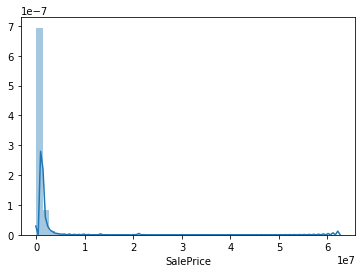

In [14]:
sns.distplot(filter_four.SalePrice)

# 5. Property is on a parcel that contains only one building.

Because the sales data does not have a way to specify which building on a given parcel is being sold, we limited our data set to only include parcels that have one building one them.

## Creating PINS
In order to find which parcels have multiple buildings on them, we will ned the resbldg data set and a way to join that dataset with our sales dataset.

In [15]:
res_bldg = data_cleaning.add_PIN_column(res_bldg)
filter_four = data_cleaning.add_PIN_column(filter_four)

/home/max/flatiron/chi-ds/module_2/week_3/projects/mod2_housing_sales/src/data_cleaning.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Major'] = df['Major'].apply(str)
/home/max/flatiron/chi-ds/module_2/week_3/projects/mod2_housing_sales/src/data_cleaning.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Minor'] = df['Minor'].apply(str)
/home/max/flatiron/chi-ds/module_2/week_3/projects/mod2_housing_sales/src/data_cleaning.py:48: SettingWithCopyWarning: 
A value is trying to be set on a cop

# Filtering by number of buildings per parcel

First I grouped the res_bldg data by PIN and then counted the number of buildings.

In [16]:
number_of_buildings = res_bldg.groupby('PIN').BldgNbr.count()
number_of_buildings.sort_values()

PIN
0000400001     1
6127600080     1
6127600075     1
6127600070     1
6127600065     1
              ..
2422079026    16
2722059164    19
0822119001    21
3223059036    28
1522049091    31
Name: BldgNbr, Length: 509573, dtype: int64

### Then I created a dataframe with only the pins that have one building.

In [17]:
one_building_parcels = pd.DataFrame(number_of_buildings[number_of_buildings==1].index) 
one_building_parcels = one_building_parcels.set_index('PIN')
one_building_parcels

""
PIN
0000400001
0001000003
0001000009
0001000035
0001000040
...
9906000060
9906000065
9906000080


### Then I did an inner join on the sales data to find the overlap between 2019 sales and parcels that have only one building on them.

In [18]:
filter_five = pd.merge(filter_four, one_building_parcels, how='inner', on='PIN')
filter_five

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,,...,6,3,N,N,N,N,1,8,,1402810020
3,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
4,2980648,797320,2320,2019-03-27,540000,,,,,,...,6,3,N,N,N,N,1,8,,7973202320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28766,2972689,929085,0760,2019-01-25,1205000,20190206001611,,,,,...,6,24,N,N,N,N,18,8,12,9290850760
28767,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,,...,6,3,N,N,N,N,1,8,,4059400095
28768,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,,...,6,3,N,N,N,N,1,8,,3816700025
28769,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,,...,6,3,N,N,N,N,1,8,,6150200505


This has a noticable effect on the data.

In [19]:
len(filter_five) - len(filter_four)

-2353

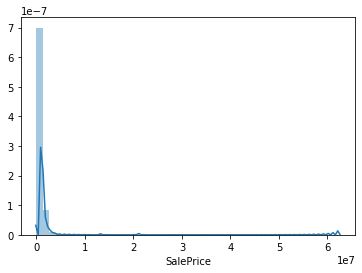

In [20]:
sns.distplot(filter_five.SalePrice)

# Outlier removal

In [21]:
z = np.abs(stats.zscore(filter_five.SalePrice))
no_outliers = filter_five[z < 3]

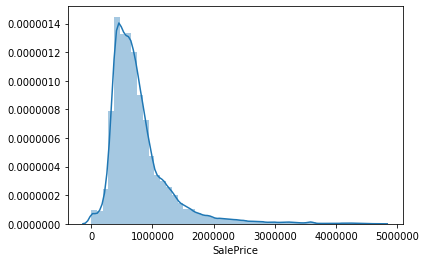

In [22]:
sns.distplot(no_outliers.SalePrice)

# Final PINs creation

I will create a csv containing only the unique pins of the properties that fall under our criteria. The PIN csv will be created from the unique values of the PIN column from my filter_five dataframe. This PINS.csv file can be used to filter any additional datasets we have.

In [23]:
unique_pins = filter_five.PIN.unique()

PINS = pd.DataFrame(unique_pins, columns=['PIN']).set_index('PIN')
PINS.to_csv(data_folder+'PINS.csv')
PINS

""
PIN
2130430120
9406520630
1402810020
1245500098
7973202320
...
9290850760
4059400095
3816700025


# Export

In [24]:
res_bldg_final = pd.merge(res_bldg, PINS, on='PIN', how='inner')
res_bldg_final

,Major,Minor,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,PIN
0,010050,0380,1,1,2435 S 354TH ST 98003,2435,,S,354TH,ST,...,0,0,1994,0,0,0,0,5,0,0100500380
1,017900,0315,1,1,12254 43RD AVE S 98178,12254,,,43RD,AVE,...,0,0,1942,0,0,0,0,3,0,0179000315
2,018800,0095,1,1,1602 LAKEVIEW BLVD E 98102,1602,,,LAKEVIEW,BLVD,...,0,0,1984,0,0,0,0,3,0,0188000095
3,018880,0210,1,1,3410 SE 18TH ST,3410,,SE,18TH,ST,...,0,1,2019,0,49,0,0,3,0,0188800210
4,019110,0145,1,1,4512 90TH AVE SE 98040,4512,,,90TH,AVE,...,0,0,1950,0,0,0,0,4,0,0191100145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28005,195440,0120,1,1,22131 NE 9TH PL 98074,22131,,NE,9TH,PL,...,0,0,1987,0,0,0,0,4,0,1954400120
28006,195970,1472,1,1,2857 FRANKLIN AVE E,2857,,,FRANKLIN,AVE,...,0,0,2016,0,0,0,0,3,0,1959701472
28007,197220,0269,1,1,3616 PALATINE AVE N,3616,,,PALATINE,AVE,...,0,0,2017,0,0,0,0,3,5000,1972200269
28008,197220,1902,1,1,3816 WINSLOW PL N 98103,3816,,,WINSLOW,PL,...,0,0,2003,0,0,0,0,3,0,1972201902


In [25]:
res_bldg_final.to_csv(data_folder+'EXTR_ResBldg_final.csv')

filter_five.to_csv(data_folder+'EXTR_RPSale_final.csv')

# Adding more data

First, make sure you import the original csv with the right arguments, it may need special encoding, and it may need you to specifiy data type.

In [26]:
#note that some csv's need tobe read with an encoding argument set to 'latin-1'
parcel = pd.read_csv(data_folder+'EXTR_Parcel.csv', dtype={'Major': 'string', 'Minor':'string'}, encoding='latin-1')
accessory = pd.read_csv(data_folder+'EXTR_Accessory_V.csv', dtype={'Major': 'string', 'Minor':'string'}, encoding='latin-1')

Then, filter the file by our PINS

In [27]:
parcel = data_cleaning.add_PIN_column(parcel)
accessory = data_cleaning.add_PIN_column(accessory)

Check to make sure it looks okay.

In [28]:
parcel.head()

,Major,Minor,PropName,PlatName,PlatLot,PlatBlock,Range,Township,Section,QuarterSection,...,LandslideHazard,SteepSlopeHazard,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems,PIN
0,807841,0410,,SUMMER RIDGE DIV NO. 02,41,,6,25,22,SW,...,N,N,N,N,N,N,N,N,N,8078410410
1,201920,0030,,DEVILLE MANOR,3,,4,21,28,SE,...,N,N,N,N,N,N,N,N,N,2019200030
2,755080,0015,,SANDER'S TO GILMAN PK & SALMON BAY,3,1,3,25,11,NW,...,N,N,N,N,N,N,N,N,N,7550800015
3,888600,0135,,VASHON GARDENS ADD,21,,3,22,8,NE,...,N,N,N,N,N,N,N,N,N,8886000135
4,643000,0185,,OSNERS 1ST ADD,37-38,1,4,25,6,NW,...,N,N,N,N,N,N,N,N,N,6430000185


In [29]:
accessory.head()

,Major,Minor,AccyType,AccyDescr,Quantity,Size,Unit,Grade,EffYr,PcntNetCondition,AccyValue,DateValued,UpdatedBy,UpdateDate,PIN
0,414010,0060,17,,8,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4140100060
1,423240,1120,17,,4,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4232401120
2,423540,0735,14,,33,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4235400735
3,430220,1165,17,,4,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4302201165
4,430220,1170,17,,4,0,0,0,0,0,0,1900-01-01 00:00:00,,1900-01-01 00:00:00,4302201170


Filter with the list of PINs

In [30]:
PINS = pd.read_csv(data_folder+'PINS.csv', dtype={'PIN': 'string'})
PINS = PINS.set_index('PIN')


parcel_final = parcel.join(PINS, how='inner', on='PIN')
print('finished parcels')

accessory_final = accessory.join(PINS, how='inner', on='PIN')
print('finished accessory')

finished parcels
finished accessory


Export it the data file, with the suffix '_final'

In [31]:
parcel_final.to_csv(data_folder+'EXTR_Parcel_final.csv')
accessory_final.to_csv(data_folder+'EXTR_Accessory_V_final.csv')